In [152]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from pathlib import Path
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates

sys.path.append(os.path.expanduser('~/Documents/Weave'))
from Weave.utils import collapse_restore_multiindex, get_nhplus, get_nhmin, get_europe
from Weave.models import HybridExceedenceModel

from Weave.inspection import ImportanceData, MapInterface, mapplot

In [4]:
basepath = Path('/nobackup_1/users/straaten/')
#basepath = Path('/scistor/ivm/jsn295/')
# Latest results:
quantile = 0.666 # options: 0.666 and 0.8
inputpath = basepath / 'clusters_cv_spearmanpar_varalpha_strict' # Latest dimreduced X and y data 
anompath = basepath / 'processed'
permtrainpath = basepath / f'permimp_train_q0{str(quantile)[2:]}'
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
respagg = 31
separation = -7
permtrain = ImportanceData(permtrainpath, respagg, separation, quantile, model)
permtrain.load_data(inputpath=inputpath, X_too = True, y_too = True)
permtrain.scale_within(fill_na = True)

### Illustration data
Tcc chosen for its slight (not large separation) importance. And consistency of correlation patterns.

Rowkeys are thinned, so you could be losing some information here if not also present in the xarray name or attributes


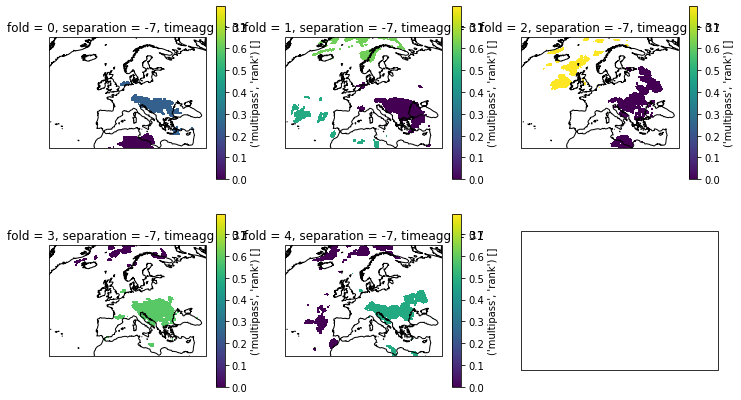

In [6]:
mapint = MapInterface(corclustpath=inputpath, anompath= anompath, impdata=permtrain)
metricsep = permtrain.df.index.get_loc_level('spatcov','metric')[0]
frame = permtrain.df.loc[metricsep,:].loc[(slice(None),slice(None),'tcc_europe',31),('multipass','rank')]
mapplot(mapint.map_to_fields(frame), wrap_per_row=3,match_scales=True, region = get_europe())
plt.show()

In [20]:
snapshotindex = 3441 # 8th of july, peak in zeroth fold is actually later.
lineplotslice = slice(3430,3480)

## Quick and dirty
Getting values of the 2018 period, which shows large response in the interesting / important cluster of the med low.

3468 for the zeroth fold X peak (august 2018) 3130 (summer 2015) for 4th fold peak
We need match the line plot colors to clustid

In [21]:
permtrain.X.loc[(slice(None),'tcc_europe',31,slice(None),-7,slice(None),'spatcov'),:].iloc[:,[snapshotindex]]

time                                                    2018-07-08
fold variable   timeagg lag separation clustid metric             
3    tcc_europe 31      -38 -7         0       spatcov    0.002791
                                       1       spatcov    0.000796
2    tcc_europe 31      -38 -7         0       spatcov    0.002434
                                       1       spatcov    0.000028
                                       2       spatcov    0.000409
1    tcc_europe 31      -38 -7         0       spatcov    0.008092
                                       1       spatcov    0.001887
                                       2       spatcov    0.001696
0    tcc_europe 31      -38 -7         0       spatcov   -0.000631
                                       1       spatcov    0.002130
4    tcc_europe 31      -38 -7         0       spatcov    0.000244
                                       1       spatcov    0.001327
                                       2       spatcov    0.000068

In [ ]:
permtrain.X.loc[(slice(None),'tcc_europe',31,slice(None),-7,slice(None),'spatcov'),:].iloc[:,lineplotslice].T.plot(legend = False)

In [ ]:
r = mapint.get_anoms(permtrain.X.loc[(slice(None),'tcc_europe',31,slice(None),-7,slice(None),'spatcov'),:].iloc[:,[snapshotindex]], mask_with_clustid=True)
mapplot(r,match_scales = False, region=get_europe())
plt.show()

## Elaborate
Match the correlation scales. Mask the anomaly field? Custom colors for the clusterids. Extract all info from the r object. No colorbar for clusterid (displayed in the lineplot)

In [207]:
anomfields = [l[0] for l in r.listofarrays]
corfields = [l[1] for l in r.listofarrays]
clustfields = [l[2] for l in r.listofarrays]
Xdata = permtrain.X.loc[(slice(None),'tcc_europe',31,slice(None),-7,slice(None),'spatcov'),:].iloc[:,lineplotslice]

In [208]:
new_clustids = pd.RangeIndex(100, 100 + Xdata.shape[0], name = 'clustid')
Xdata.index = pd.MultiIndex.from_arrays([Xdata.index.get_level_values('fold'),new_clustids])

In [210]:
# replace the clustids in clustfields. and get the right colors.
toreplace = 0
for i in range(len(clustfields)):
    minid = int(clustfields[i].min())
    maxid = int(clustfields[i].max())
    for clustid in range(minid, maxid+1):
        print(f'current {clustid}, new {new_clustids[toreplace]}')
        clustfields[i] = clustfields[i].where(clustfields[i] != clustid, other = new_clustids[toreplace])
        toreplace += 1

current 0, new 100
current 1, new 101
current 0, new 102
current 1, new 103
current 2, new 104
current 0, new 105
current 1, new 106
current 2, new 107
current 0, new 108
current 1, new 109
current 0, new 110
current 1, new 111
current 2, new 112


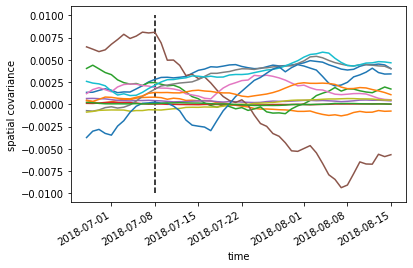

In [220]:
colors = []
fig, ax = plt.subplots()
for cl in new_clustids:
    lines = ax.plot(Xdata.columns.values, Xdata.loc[(slice(None),cl),:].values.squeeze())
    colors.append(lines[0].get_color())
stamp = permtrain.X.columns[snapshotindex]
ax.vlines(stamp.to_numpy(),ymin = -0.01, ymax= 0.01, linestyle = 'dashed', color = 'black')
fig.autofmt_xdate()
#ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_ylabel('spatial covariance')
ax.set_xlabel('time')
plt.show()

In [131]:
cmap = ListedColormap(colors)

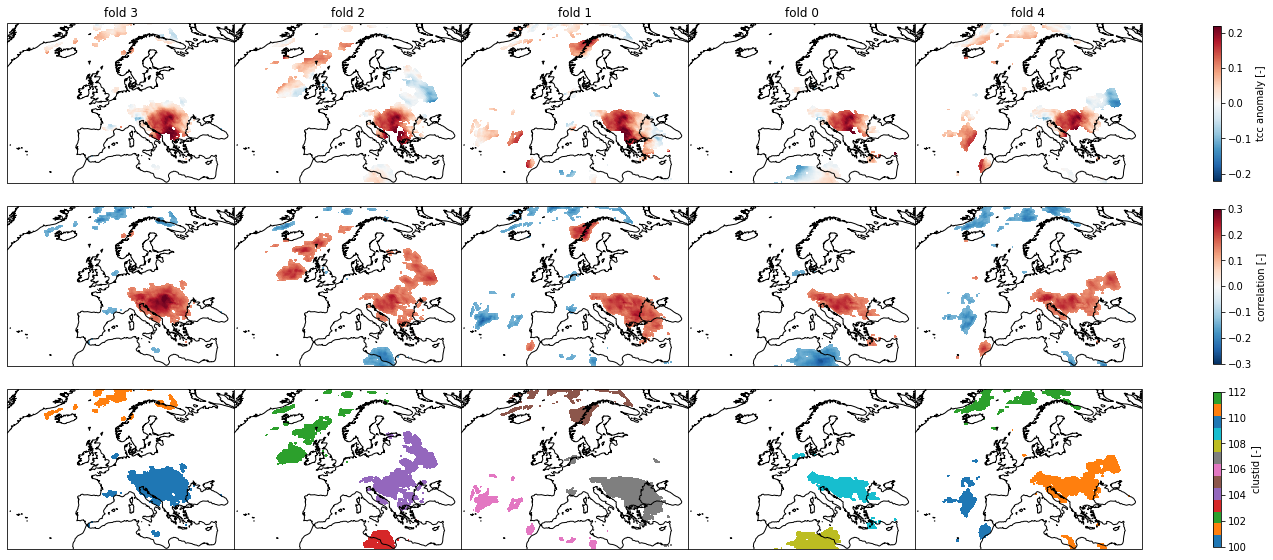

In [187]:
def data_for_pcolormesh(array):
    """Xarray array to usuable things"""
    lats = array.latitude.values # Interpreted as northwest corners (90 is in there)
    lons = array.longitude.values # Interpreted as northwest corners (-180 is in there, 180 not)
    lats = np.concatenate([lats[[0]] - np.diff(lats)[0], lats], axis = 0) # Adding the sourthern edge 
    lons = np.concatenate([lons, lons[[-1]] + np.diff(lons)[0]], axis = 0)# Adding the eastern edge
    return lons, lats, array.values

region = get_europe()
extent = np.array(region[1:])[[1,3,2,0]]  # drop the name and reorder to x0,x1,y0,y1
array_crs = ccrs.PlateCarree()
fig, axes = plt.subplots(ncols=len(clustfields), nrows = 3, squeeze = False, sharex = True, sharey = True, 
                         figsize = (20,8), subplot_kw = dict(projection=ccrs.Mollweide()))
# Make the anomalies
for i, field in enumerate(anomfields):
    ax = axes[0,i]
    imanom = ax.pcolormesh(*data_for_pcolormesh(field), shading = 'flat', transform = array_crs, cmap = 'RdBu_r', vmin = -0.22, vmax = 0.22)
    ax.set_extent(tuple(extent), crs = array_crs)
    ax.coastlines()
    ax.set_title(f'fold {int(field.coords["fold"].values)}')


# Make the correlationpaths
for i, field in enumerate(corfields):
    ax = axes[1,i]
    imcor = ax.pcolormesh(*data_for_pcolormesh(field), shading = 'flat', transform = array_crs, cmap = 'RdBu_r', vmin = -0.3, vmax = 0.3)
    ax.set_extent(tuple(extent), crs = array_crs)
    ax.coastlines()

# Make the correlationpaths
for i, field in enumerate(clustfields):
    ax = axes[2,i]
    imclust = ax.pcolormesh(*data_for_pcolormesh(field), shading = 'flat', transform = array_crs, cmap = cmap, vmin = new_clustids.min(), vmax = new_clustids.max())
    ax.set_extent(tuple(extent), crs = array_crs)
    ax.coastlines()
fig.canvas.draw()
plt.tight_layout()
cbar = fig.colorbar(imanom, ax = list(axes[0]), shrink = 0.9)
cbar.set_label('tcc anomaly [-]')
cbar = fig.colorbar(imcor, ax = list(axes[1]), shrink = 0.9)
cbar.set_label('correlation [-]')
cbar = fig.colorbar(imclust, ax = list(axes[2]), shrink = 0.9)
cbar.set_label('clustid [-]')
plt.show()

### Small plot for illustrating the full form of the anomalies

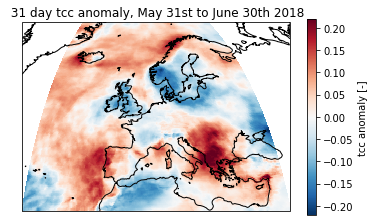

In [228]:
temp = mapint.get_anoms(permtrain.X.loc[(slice(None),'tcc_europe',31,slice(None),-7,slice(None),'spatcov'),:].iloc[[0],[snapshotindex]], mask_with_clustid=False)
anomfield = temp.listofarrays[0][0]
fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.Mollweide()))
im = ax.pcolormesh(*data_for_pcolormesh(anomfield), shading = 'flat', transform = array_crs, cmap = 'RdBu_r', vmin = -0.22, vmax = 0.22)
ax.set_extent(tuple(extent), crs = array_crs)
ax.coastlines()
ax.set_title(f' 31 day tcc anomaly, May 31st to June 30th 2018')
cbar = fig.colorbar(im, ax = ax, shrink = 0.9)
cbar.set_label('tcc anomaly [-]')